In [1]:
import pandas as pd

with open("../data/slippage/eth_usdc_0_05.csv","r") as infile: eth_usdc_0_05_data = pd.read_csv(infile)
with open("../data/slippage/eth_usdc_0_3.csv","r") as infile: eth_usdc_0_3_data = pd.read_csv(infile)
with open("../data/slippage/usdct_usdt_0_01.csv","r") as infile: usdct_usdt_0_01_data = pd.read_csv(infile)
with open("../data/slippage/dai_usdc_0_01.csv","r") as infile: dai_usdc_0_01_data = pd.read_csv(infile)

print(eth_usdc_0_05_data.columns)

Index(['amount0_adjusted', 'amount1_adjusted', 'price_implied', 'price_actual',
       'previous_price_actual', 'price_movement_percentage', 'evt_tx_hash',
       'evt_block_number', 'evt_block_time', 'evt_index'],
      dtype='object')


In [7]:
#### Start of the Slippage Analysis

# Empirical slippage analysis
import csv
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# token0 is usdc, token1 is eth
def process_trades(df,name,vol_window=30,type="collateral"):
    df.rename(columns={"amoun0_adjusted":"amount0_adjusted"},inplace=True)
    df.rename(columns={"amoun1_adjusted":"amount1_adjusted"},inplace=True)
    
    if type=="collateral":
        df["trade_size_x"]=df["amount1_adjusted"].apply(lambda x: abs(x/1.0e12))
        df["trade_size_y"]=df["amount0_adjusted"].apply(lambda x: abs(x*1.0e12))
    else:
        df["trade_size_x"]=df["amount1_adjusted"].apply(lambda x: abs(x))
        df["trade_size_y"]=df["amount0_adjusted"].apply(lambda x: abs(x))
    
    df["price_implied"] = 1e24/df["price_implied"]
    df["price_actual"] = 1e24/df["price_actual"]
    df["previous_price_actual"] = 1e24/df["previous_price_actual"]
    df["price_impact"]=abs(df["price_actual"]-df["previous_price_actual"])/abs(df["previous_price_actual"])
    df["evt_block_time"] = pd.to_datetime(df['evt_block_time'], utc=True)
    df['unix_timestamp'] = df['evt_block_time'].astype(int) // 10**9
    df.sort_values(by="unix_timestamp", axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
    df['date'] = pd.to_datetime(df['unix_timestamp'], unit='s').dt.date
    daily_df = df.groupby(["date"]).agg({"price_impact": "std","unix_timestamp":["first","last"],"price_actual":"mean"}).rename(columns={"price_impact": "volatility"})    
    df_reset = daily_df.reset_index()
    df_reset.columns = ['_'.join(col).rstrip('_') for col in df_reset.columns.values]
    df_reset['rolling_volatility'] = df_reset['volatility_std'].rolling(window=vol_window).mean()*((252 ** 0.5))
    merged_df = pd.merge_asof(df, df_reset, left_on='unix_timestamp', right_on='unix_timestamp_first',direction='backward')
    merged_df = merged_df.dropna()
    merged_df["new_cross_impact"]=merged_df["rolling_volatility"]*merged_df["trade_size_x"]
    return(merged_df)    

def plot_stats(merged_df,name,type="collateral"):
    print(merged_df.columns,merged_df.shape)

    plt.figure()
    # plt.plot(merged_df["date_x"],merged_df["std_price"]/merged_df["price_actual_mean"], label='std_price')
    plt.plot(merged_df["date_x"],merged_df["rolling_volatility"],label='rolling_volatility')
    plt.scatter(merged_df["date_x"],merged_df["price_impact"],label='price_impact',alpha=0.1,c=merged_df["trade_size_x"],cmap='viridis')
    plt.legend()
    plt.title(name)
    cbar = plt.colorbar()
    cbar.set_label('Trade Size')
    plt.show()

    ##############################################
    print(merged_df[["price_impact", "trade_size_x"]])
    plt.figure()
    plt.plot(merged_df["date_x"], merged_df["rolling_volatility"], label='rolling_volatility')
    ax2 = plt.twinx()
    scatter = ax2.scatter(merged_df["date_x"], 100 * merged_df["price_impact"] / merged_df["trade_size_x"], label='price_impact/trade_size', alpha=0.1, c=merged_df["rolling_volatility"], cmap='viridis')
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Rolling Volatility')
    plt.title(name)
    handles1, labels1 = plt.gca().get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    plt.legend()
    plt.show()


    plt.figure()
    plt.scatter(merged_df["trade_size_x"],merged_df["price_impact"],c=merged_df["rolling_volatility"],cmap='viridis')
    plt.title(name)
    plt.show()

    plt.figure()
    plt.plot(merged_df["unix_timestamp"],merged_df["price_actual"])    
    plt.title(name)
    plt.show()
    return(merged_df)

def gen_multi_var_reg(df, x_vars, y_var):    
    # Define input (X) and output (y) variables
    X = df[x_vars]
    y = df[y_var]

    # Add a constant term for the intercept
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # # Get the summary
    # print(model.summary())

    # # To get individual components (parameters, R-squared, etc.)
    # print("Parameters:", model.params)
    # print("R-squared:", model.rsquared)
    return model

def lin_reg(df, x_var="trade_size_x", y_var="price_impact",name=None,color_var="rolling_volatility"):
    print("lin_reg")
    # Linear regression
    # Generate Y-values based on the regression model
    p, cov = np.polyfit(df[x_var], df[y_var], 1, cov=True)  # Assuming x and y are your data arrays
    slope = p[0]
    intercept = p[1]
    errors = np.sqrt(np.diag(cov))
    y_fit = slope * df[x_var] + intercept
    print(slope,intercept,errors)
    plt.scatter(x=df[x_var], y=df[y_var], label='Data', c=df[color_var], cmap='viridis')
    plt.plot(df[x_var], y_fit, label=f'Fit: y = {slope:.6f}x + {intercept:.6f}', color='firebrick')
    if x_var=="trade_size_x":
        plt.xlabel("Trade Size")
    else:
        plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.legend()
    plt.title(name)
    cbar = plt.colorbar()
    cbar.set_label(color_var)
    plt.show()
    return(p, cov)

def plot_3d_relationships(df,x_var,y_var,z_var):
    if x_var=="amount1_adjusted": 
        x_var_name = "Trade Size"
        df[x_var+'_bin'] = df[x_var].round()
    else:
        x_var_name = y_var
        df[x_var+'_bin'] = df[x_var].round(2)
        
    df[y_var+'_bin'] = df[y_var].round(4)
    df[z_var+'_bin'] = df[z_var].round(0)
    
    df2=df.groupby([x_var+'_bin',y_var+'_bin']).agg({z_var: "mean"}).reset_index()
    fig = px.scatter(df2,x=x_var+'_bin',y=z_var,color=y_var+'_bin')
    fig.update_layout(
        xaxis=dict(type='linear', title=x_var_name+"_bin"),
        yaxis=dict(type='linear', title=z_var),
        title_text=x_var_name+'_bin vs'+z_var
    )
    fig.show()

    df3=df.groupby([y_var+'_bin',x_var+'_bin']).agg({z_var: "mean"}).reset_index()   
    fig = px.scatter(df3,x=y_var+'_bin',y=z_var,color=x_var+'_bin')
    fig.update_layout(
        xaxis=dict(type='linear', title=y_var+"_bin"),
        yaxis=dict(type='linear', title=z_var),
        title_text=y_var+'_bin vs '+z_var
    )
    fig.show()

Index(['amount0_adjusted', 'amount1_adjusted', 'price_implied', 'price_actual',
       'previous_price_actual', 'price_movement_percentage', 'evt_tx_hash',
       'evt_block_number', 'evt_block_time', 'evt_index', 'trade_size_x',
       'trade_size_y', 'price_impact', 'unix_timestamp', 'date_x', 'date_y',
       'volatility_std', 'unix_timestamp_first', 'unix_timestamp_last',
       'price_actual_mean', 'rolling_volatility', 'new_cross_impact'],
      dtype='object') (340687, 22)


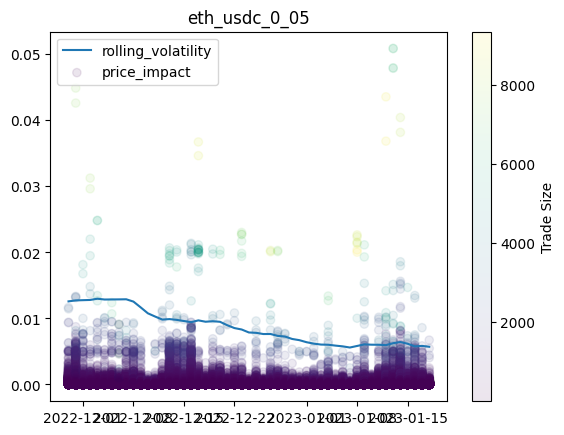

        price_impact  trade_size_x
301968  8.039671e-06      2.616330
301969  2.055533e-07      0.066859
301970  6.102001e-06      1.984781
301971  6.082723e-06      1.978776
301972  2.740878e-04     89.189865
...              ...           ...
642650  1.629594e-05      5.500000
642651  5.102590e-06      1.722181
642652  9.403440e-07      0.317219
642653  2.256822e-06      0.761325
642654  9.421894e-07      0.318000

[340687 rows x 2 columns]


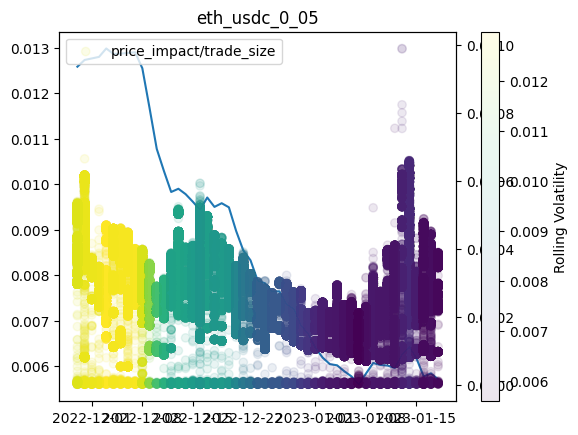

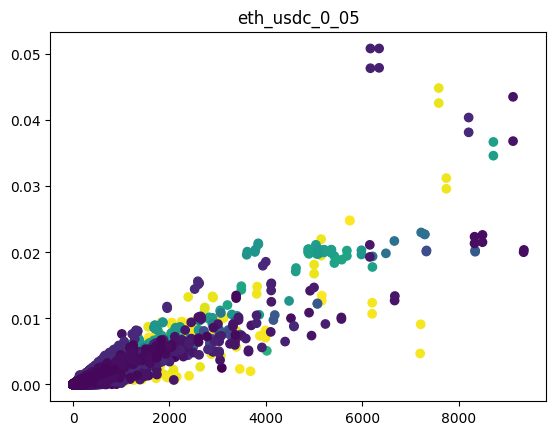

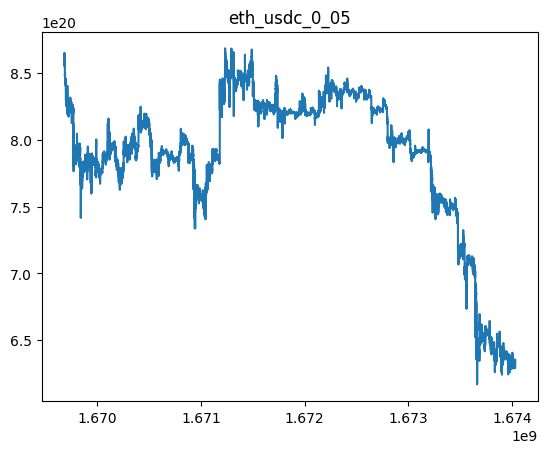

,amount0_adjusted,amount1_adjusted,price_implied,price_actual,previous_price_actual,price_movement_percentage,evt_tx_hash,evt_block_number,evt_block_time,evt_index,...,price_impact,unix_timestamp,date_x,date_y,volatility_std,unix_timestamp_first,unix_timestamp_last,price_actual_mean,rolling_volatility,new_cross_impact
301968,-3.054178e-09,2.616330e+12,8.566399e+20,8.562150e+20,8.562081e+20,8.039671e-06,0x3a53e3eda213ab0f09350f0ece4deace3a9544c3999f...,16071931.0,2022-11-29 00:00:11+00:00,387,...,8.039671e-06,1669680011,2022-11-29,2022-11-29,0.000400,1669680011,1669766399,8.297833e+20,0.012582,0.032919
301969,7.812688e-11,-6.685942e+10,8.557801e+20,8.562081e+20,8.562083e+20,-2.055533e-07,0x67ce5cadf0a94b910263bd1a7925e4a814ed2026e43e...,16071931.0,2022-11-29 00:00:11+00:00,343,...,2.055533e-07,1669680011,2022-11-29,2022-11-29,0.000400,1669680011,1669766399,8.297833e+20,0.012582,0.000841
301970,2.319254e-09,-1.984781e+12,8.557843e+20,8.562097e+20,8.562150e+20,-6.102001e-06,0xce69ce9338f55ee833bc01d5fb79385e4d18be8a834b...,16071932.0,2022-11-29 00:00:23+00:00,5,...,6.102001e-06,1669680023,2022-11-29,2022-11-29,0.000400,1669680011,1669766399,8.297833e+20,0.012582,0.024972
301971,2.311617e-09,-1.978776e+12,8.560136e+20,8.564392e+20,8.564444e+20,-6.082723e-06,0x4b48827569c3c052f4aaca060bb204d46867ad7cd980...,16071932.0,2022-11-29 00:00:23+00:00,46,...,6.082723e-06,1669680023,2022-11-29,2022-11-29,0.000400,1669680011,1669766399,8.297833e+20,0.012582,0.024897
301972,-1.041019e-07,8.918987e+13,8.567555e+20,8.564444e+20,8.562097e+20,2.740878e-04,0x606d02802a99295c4e926dd8df508a0dfc523f8d868e...,16071932.0,2022-11-29 00:00:23+00:00,9,...,2.740878e-04,1669680023,2022-11-29,2022-11-29,0.000400,1669680011,1669766399,8.297833e+20,0.012582,1.122185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642650,-8.660530e-09,5.500000e+12,6.350650e+20,6.347527e+20,6.347423e+20,1.629594e-05,0x127c7e706d1ae73a386a417c8bd05ff3b06cc60bf80a...,16432637.0,2023-01-18 08:57:11+00:00,308,...,1.629594e-05,1674032231,2023-01-18,2023-01-18,0.000245,1674000011,1674032291,6.327160e+20,0.005711,0.031410
642651,-2.711789e-09,1.722181e+12,6.350718e+20,6.347559e+20,6.347527e+20,5.102590e-06,0x17a53aadbebd9f469b7ca80e8b96f523255d45c5711e...,16432639.0,2023-01-18 08:57:35+00:00,48,...,5.102590e-06,1674032255,2023-01-18,2023-01-18,0.000245,1674000011,1674032291,6.327160e+20,0.005711,0.009835
642652,5.000000e-10,-3.172191e+11,6.344382e+20,6.347553e+20,6.347559e+20,-9.403440e-07,0xd0aba9dfe293cad89927ee82b78f8ba855e4dc670580...,16432639.0,2023-01-18 08:57:35+00:00,63,...,9.403440e-07,1674032255,2023-01-18,2023-01-18,0.000245,1674000011,1674032291,6.327160e+20,0.005711,0.001812
642653,1.200000e-09,-7.613247e+11,6.344372e+20,6.347539e+20,6.347553e+20,-2.256822e-06,0xf52d634c36bcc5c815625191c97b704b54145170fa1e...,16432641.0,2023-01-18 08:57:59+00:00,23,...,2.256822e-06,1674032279,2023-01-18,2023-01-18,0.000245,1674000011,1674032291,6.327160e+20,0.005711,0.004348


In [9]:
eth_usdc_0_05_df = process_trades(df=eth_usdc_0_05_data,name="eth_usdc_0_05",vol_window=30,type="collateral")
plot_stats(merged_df=eth_usdc_0_05_df,name="eth_usdc_0_05",type="collateral")

# eth_usdc_0_3_df = process_trades(eth_usdc_0_3_data,"eth_usdc_0_3_df",vol_window=30,type="collateral")
# usdct_usdt_0_01_df = process_trades(usdct_usdt_0_01_data,name="usdct_usdt_0_01",vol_window=30,type="stables")
# dai_usdc_0_01_df = process_trades(dai_usdc_0_01_data,name="dai_usdc_0_01",vol_window=30,type="stables")

In [ ]:
ols1 = gen_multi_var_reg(eth_usdc_0_05_df,x_vars=["rolling_volatility","amount1_adjusted"],y_var=["price_impact"])
intercept = ols1.params[0]  # This is the intercept (often denoted as 'b0')
slopes = ols1.params[1:]    # These are the slopes (coefficients for the predictors, 'b1', 'b2', ...)
print("rsquared",ols1.rsquared)
print("rsquared_adj",ols1.rsquared_adj)
print("intercept",intercept)
print("slopes",slopes)

p,cov = lin_reg(eth_usdc_0_05_df, x_var="amount1_adjusted", y_var="price_impact",name="Trade Size vs Price Impact",color_var="rolling_volatility")
slope = p[0]
intercept = p[1]
errors = np.sqrt(np.diag(cov))
y_fit = slope * eth_usdc_0_05_df["amount1_adjusted"] + intercept

p,cov = lin_reg(eth_usdc_0_05_df, x_var="new_cross_impact", y_var="price_impact",name="Trade Size x Volatility vs Price Impact",color_var="unix_timestamp")
slope = p[0]
intercept = p[1]
errors = np.sqrt(np.diag(cov))
y_fit = slope * eth_usdc_0_05_df["new_cross_impact"] + intercept

plot_3d_relationships(df=eth_usdc_0_3_df,x_var="amount1_adjusted",y_var="rolling_volatility",z_var="price_impact")

In [ ]:
ols2 = gen_multi_var_reg(eth_usdc_0_3_df,x_vars=["rolling_volatility","amount1_adjusted"],y_var=["price_impact"])
print(ols2)

In [ ]:
ols3 = gen_multi_var_reg(usdct_usdt_0_01_df,x_vars=["rolling_volatility","amount1_adjusted"],y_var=["price_impact"])
print(ols3)

In [ ]:
ols4 = gen_multi_var_reg(dai_usdc_0_01_df,x_vars=["rolling_volatility","amount1_adjusted"],y_var=["price_impact"])
print(ols4)

In [ ]:
lin_reg(eth_usdc_0_05_df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility")
lin_reg(eth_usdc_0_3_df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility")

lin_reg(usdct_usdt_0_01_df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility")
lin_reg(dai_usdc_0_01_df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility")

In [ ]:
lin_reg(eth_usdc_0_3_df, x_var="amount1_adjusted", y_var="new_cross_impact",name=None,color_var="rolling_volatility")
lin_reg(usdct_usdt_0_01_df, x_var="amount1_adjusted", y_var="new_cross_impact",name=None,color_var="rolling_volatility")
lin_reg(dai_usdc_0_01_df, x_var="amount1_adjusted", y_var="new_cross_impact",name=None,color_var="rolling_volatility")

In [ ]:
# plot_3d_relationships(eth_usdc_0_05_df)
plot_3d_relationships(eth_usdc_0_3_df)
plot_3d_relationships(usdct_usdt_0_01_df)
# plot_3d_relationships(dai_usdc_0_01_df)

In [ ]:
import plotly.express as px
import numpy as np
# new slippage function based on empirical analysis
def quad_output(x):
    """
    @notice calculate price impact when selling x or y to the open market.
    Assuming that we trade against Uniswap is a conservative assumption
    """
    a,b,c = (2.602424822058012e-10,2.3009044333523045e-07,0.0004613261845851614)
    return(a*x**2+b*x+c)

x = np.logspace(-9,5, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
y = [quad_output(x) for x in x]
fig=px.line(x=x, y=y)
fig.show()

def lin_output(x):
    return 1.081593506690093e-06*x+0.0004379110082802476

x = np.logspace(-9,5, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
print(x)
y = [lin_output(x) for x in x]
fig=px.line(x=x, y=y)
fig.show()